<a id="cont"></a>

## Table of Contents

<a href=#one>1. Introduction</a>

<a href=#two>2. Importing Packages</a>

<a href=#three>3. Loading Data</a>

<a href=#four>4. Exploratory Data Analysis (EDA)</a>

<a href=#five>5. Data Engineering</a>

<a href=#six>6. Modeling</a>

<a href=#seven>7. Model Performance</a>

<a href=#eight>8. Model Explanations</a>

 <a id="one"></a>
## 1. Introduction
<a href=#cont>Back to Table of Contents</a>

**Project Overview**

After decades receiving little attention from non-scientists, the impacts of climate change are now widely discussed through a variety of mediums. Originating from scientific papers, newspaper articles, and blog posts, a broad spectrum of climate change opinions, subjects, and sentiments exist. Newspaper articles often dismiss or sensationalize the effects of climate change due to journalistic biases including personalization, dramatization and a need for novelty. Scientific papers portray a much more realistic and consensus view of climate change. These views, however, do not receive widespread media attention due to several factors including journal paywalls, formal scientific language, and technical results that are not easy for the general public to understand. 

In the last decade, there has been a shift from the consumption of traditional mass media (newspapers and broadcast television) to the consumption of social media (blog posts, Twitter, etc.). This shift represents a switch in communications from “one-to-many” to “many-to-many”. Rather than a single journalist or scientist telling the public exactly what to think, social media offers a mechanism for many people of diverse backgrounds to communicate and form their own opinions. Exposure is a key aspect in transforming a social problem into a public issue, and social media is a potential avenue where climate change issues can be initially exposed.

In this project, we analyze a dataset that aggregates tweets pertaining to climate change collected between Apr 27, 2015 and Feb 21, 2018. In total, we have 43943 tweets.

**Problem Statement**
Build a model that is able to classify a person's sentiment towards climate change based on their novel tweet data.


 <a id="two"></a>
## 2. Importing Packages
<a href=#cont>Back to Table of Contents</a>

In [80]:
# Libraries for data loading, data manipulation and data visulisation
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests
from requests.packages.urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)
from multiprocesspandas import applyparallel
from comet_ml import Experiment

%matplotlib inline
# set plot style
sns.set()

# Libraries for Natural Language processing
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk import PorterStemmer
from nltk.tokenize import TreebankWordTokenizer
from wordcloud import WordCloud

# Libraries for data preparation and model building
from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Setting global constants to ensure notebook results are reproducible
SEED = 42

In [82]:
experiment = Experiment(
    api_key="cbtJsKjDivb61gTUBXpeo48r7",
    project_name="classification-predict-streamlit-group3",
    workspace="michael-py",
)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/michael-py/classification-predict-streamlit-group3/a95f9b4a607c4fce81fb269c32b42781



<a id="two"></a>
## 3. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In [81]:
df = pd.read_csv('kaggle_data/train.csv')# loading the data
df_test = pd.read_csv('kaggle_data/test.csv')

<a id="three"></a>
## 4. Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

### What is EDA?

In a nutshell, exploratory data analysis (EDA) is what data analysts do with large amounts of data to uncover patterns and summarize the dataset's primary characteristics in addition to what they learn from modeling and hypothesis testing. EDA is a notion in data analytics that allows analysts to approach a database without making any assumptions. When a data analyst employs EDA, it's as if the data is revealing what they don't already know.

In [54]:
# take a peek into the dataset
df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


Here we take a quick peek into our loaded dataset and we see that there are __3__ columns of note; `sentiment`, `message` and `tweetid`

A further investigation will provide the dimensions of our dataset, that is looking at the `shape` of the data

In [55]:
df.shape

(15819, 3)

Here, we can see that our dataset is made up of __15,819__ rows and __3__ columns, as was earlier revealed.

Next let's see of all that number of data points in the dataset, how many of them do not contain any data? and what kind of data is contained in each column? These questions will be answered by looking at the information of the dataset provided by the `.info()` method.

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


The information above tells us that all of the columns in our dataset contain __15,819__ rows of data that are `non-null`, meaning we have no missing values in our dataset. This can be attested to by the information provided when we looked at the `shape` of the data above

Another interesting information to extract from this dataset will be the unique labels in the `sentiment` which is our `label` or `dependent variable`

In [57]:
sentiment_labels = list(df.sentiment.unique())
print(sentiment_labels)

[1, 2, 0, -1]


We have __4__ different labels which make up the list of all possible sentiments that can be predicted by our model(s)

__-1__: means it is a NEGATIVE sentiment
__0__: means it is a NEUTRAL sentiment
__1__: means it is a POSITIVE sentiment
__2__: means it is a FACTUAL sentiment from a reputable News Site

What are the proportions of our dataset that these labels represent? First, we will look at the figures and then we will look at a chart and barplot for better understanding  

In [58]:
labels_proportions = df.sentiment.value_counts()
labels_proportions

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

We can see that _label 1_ is very highly represented (__8,530__) and _label 2_ follows not so closely (__3,640__), which can be a good thing because it indicates that a lot of people are speaking about climate change and are aware of its impacts on our planet. _Label 0_ comes in third (__2,353__); these tweets are neutral, having no connections with climate change or its woes.

Gladly, the negative sentiments come in tops from the bottom (__1,296__). These are tweets from people that do not believe in the reality of climate change or global warming

Now the chart.

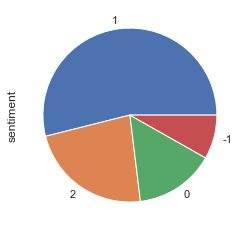

In [59]:
labels_proportions.plot(kind="pie", subplots=True)
plt.xticks(rotation=0)
plt.show()

Here we see that the biggest slice of the pie represents the _positive comments_ followed by the _factual comments/posts_ and so on, confirming what we understand from the figures. This is further demonstrated in the barplot below.

Text(0.5, 1.0, 'Class Distributions')

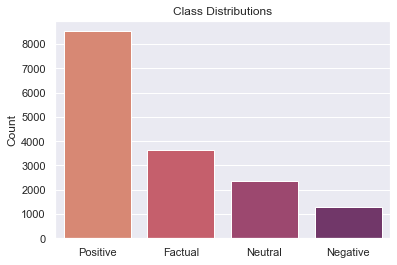

In [60]:
class_distribution = pd.DataFrame(list(df['sentiment'].value_counts()),
                          index=['Positive', 'Factual', 'Neutral', 'Negative'],
                          columns=['Count'])
sns.set()
sns.barplot(x=class_distribution.index, y=class_distribution.Count, 
           palette="flare")
plt.title('Class Distributions')

While we are glad that there are more _positive_ comments than the _neutral_ and _negative_ ones combined, this poses an issue when we try to feed the data into our machine learning algorithm. This is as a result of an __imbalance__ of the proportion of data represented by the labels in our dataset. We will dive into that further in the **data engineering** section; what data imbalance is and how to deal with it.

Out of curiosity, While it is intuitive to spot a _postive_ or a _negative_ or a _neutral_ comment, what makes a comment *factual*? hmm..

Let's look further into the data and see what we find.

We will approach this by printing a sample of messages in these different comment categories and see if we can make sense of what we find.

In [61]:
positives = df['message'][df['sentiment'] == 1]
negatives = df['message'][df['sentiment'] == -1]
neutrals = df['message'][df['sentiment'] == 0]
factuals = df['message'][df['sentiment'] == 2]

print("Positive comments:")
print(f"\t{np.array(positives[:5])}\n")
print("Negative comments:")
print(f"\t{np.array(negatives[:5])}\n")
print("Neutral comments:")
print(f"\t{np.array(neutrals[:5])}\n")
print("Factual comments:")
print(f"\t{np.array(factuals[:5])}\n")

Positive comments:
	["PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable"
 "It's not like we lack evidence of anthropogenic global warming"
 '#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD'
 "RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight"
 "Worth a read whether you do or don't believe in climate change https://t.co/ggLZVNYjun https://t.co/7AFE2mAH8j"]

Negative comments:
	['Sally Kohn’s latest evidence of climate change proves she is ‘not a smart person’ https://t.co/MhkzoGL9Vt via @twitchyteam Need we say more'
 "@realDonaldTrump Carbon Tax is a Globalist idea to enslave the world's population. It is the whole reason for propagating global warming!"
 'RT @SteveSGoddard: We had winds close to 100 MPH in the area this afternoon. I would blame climate change, except that 

At first glance, nothing particularly stands out but looking closely, only factual comments have posts from news sites like **@RawStory** and **@latimes**. A quick research into **@tveitdal** shows that he is a grandmaster in climate change and environmental consultancy, but are we to take his words as facts? hmm.. We will dive into this further during **data engineering**. 

There are no surprises in the _negative_ comments, there's a post with Donald Trump tagged.

There also seems to be a lot of links in these posts. These have to be handled one way or another as they will become "noise" in the data set. In the meantime, let's investigate this further.

**What are the words that are more frequent in each post type**

In [62]:
def words_freq(df, n):
    import string
    stop_words = stopwords.words('english')
    stop_words.append('rt')
    stop_words.append('&amp;')
    dict_ = {}
    for row in np.array(df):
        word_sw = ' '.join([l.lower() for l in row.split(' ') if l.lower() not in stop_words])
        word_punct = ''.join([l for l in word_sw if l not in string.punctuation])

        for wd in word_punct.split(" "):
            if wd in dict_:
                dict_[wd] += 1
            else:
                dict_[wd] = 1
    
    dict_ = {k: v for k,v in sorted(dict_.items(), key=lambda kv: kv[1], reverse=True)}
    n_largest = dict(list(dict_.items())[:n])
    
    return n_largest

In [63]:
pos = words_freq(positives, 60)
print(pos)

{'climate': 7328, 'change': 6873, 'global': 1592, 'warming': 1391, '': 1018, 'believe': 1000, 'trump': 877, 'going': 590, 'real': 469, 'people': 449, 'world': 443, 'us': 437, 'die': 394, 'thinking': 337, 'husband': 312, 'stephenschlegel': 307, 'httpstcosjofonã¢â‚¬â¦': 307, 'fight': 281, 'new': 281, 'like': 272, 'epa': 262, 'hoax': 252, 'sensanders': 248, 'say': 244, 'think': 234, 'need': 233, 'science': 230, 'thinks': 218, 'president': 207, 'https…': 201, 'action': 198, 'donald': 195, 'presidentelect': 192, 'right': 192, 'know': 189, 'planet': 183, 'via': 181, 'denier': 180, 'deniers': 174, 'one': 172, 'scientists': 171, 'realdonaldtrump': 164, 'stop': 164, 'still': 164, 'must': 162, 'make': 159, 'millions': 154, 'future': 154, 'tã¢â‚¬â¦': 153, 'watch': 151, 'chinese': 151, 'mr': 150, 'earth': 149, 'trumps': 147, 'take': 145, 'beforetheflood': 143, 'im': 140, 'time': 140, 'could': 137, 'would': 137}


In [64]:
neg = words_freq(negatives, 60)
print(neg)

{'climate': 781, 'change': 718, 'global': 632, 'warming': 589, '': 165, 'science': 74, 'realdonaldtrump': 68, 'us': 62, 'real': 59, 'trump': 57, 'people': 56, 'man': 52, 'would': 50, 'hoax': 50, 'scam': 49, 'made': 47, 'manmade': 46, 'data': 45, 'believe': 45, 'stevesgoddard': 44, 'make': 42, 'years': 42, 'like': 41, 'obama': 40, 'gore': 40, 'news': 35, 'al': 35, 'scientists': 35, 'money': 35, 'one': 33, 'fake': 33, 'cause': 33, 'world': 33, 'know': 32, 'tax': 31, 'chinese': 31, 'liberals': 30, 'think': 29, 'scientist': 28, 'good': 28, 'going': 28, 'left': 28, 'created': 28, 'it': 28, 'weather': 28, 'order': 27, 'leaders': 27, 'say': 26, 'due': 26, 'concept': 26, 'caused': 26, 'ice': 26, 'get': 25, 'manufacturing': 25, 'stop': 25, 'hell': 25, 'time': 24, 'manipulated': 24, 'https…': 23, 'noncompetitive': 23}


In [65]:
neu = words_freq(neutrals, 60)
print(neu)

{'climate': 1428, 'change': 1340, 'global': 1032, 'warming': 948, '': 276, 'trump': 147, 'us': 100, 'like': 96, 'real': 93, 'believe': 87, 'penguin': 84, 'think': 81, 'im': 80, 'hes': 77, 'people': 65, 'cause': 55, 'know': 52, 'one': 49, 'says': 45, 'get': 45, 'club': 44, 'new': 44, 'said': 44, 'would': 43, 'hot': 43, 'good': 39, 'world': 39, 'thing': 39, 'need': 37, 'care': 37, 'thats': 36, 'great': 36, 'right': 36, 'weather': 36, 'still': 35, 'going': 34, 'really': 34, 'want': 34, 'say': 33, 'even': 33, 'talk': 33, 'time': 32, 'much': 31, 'stop': 31, 'man': 30, 'realdonaldtrump': 30, 'hoax': 30, 'leonardo': 30, 'tell': 30, 'make': 30, 'science': 29, 'asked': 28, 'u': 28, 'today': 28, 'epa': 28, 'it': 27, 'cant': 27, 'cold': 26, 'what': 26, 'see': 26}


In [66]:
fact = words_freq(factuals, 60)
print(fact)

{'climate': 3324, 'change': 3100, 'trump': 825, '': 677, 'global': 503, 'warming': 418, 'us': 290, 'via': 286, 'says': 240, 'epa': 235, 'new': 190, 'scientists': 175, 'trumps': 165, 'donald': 162, 'fight': 158, 'china': 142, 'could': 133, 'news': 121, 'world': 113, 'scott': 112, 'paris': 110, 'chief': 100, 'energy': 100, 'president': 100, 'study': 97, 'pruitt': 96, 'science': 94, 'may': 93, 'plan': 88, 'thehill': 82, 'agreement': 79, 'carbon': 78, 'cnn': 78, 'exxon': 78, 'head': 76, 'obama': 76, 'environment': 73, 'https…': 72, 'tillerson': 71, 'house': 69, 'report': 69, 'change…': 68, 'reuters': 67, 'un': 66, 'website': 64, 'order': 64, 'back': 64, 'climatechange': 63, 'trump’s': 63, 'say': 62, 'guardian': 62, 'years': 59, 'due': 59, 'rex': 58, 'leaders': 58, 'dioxide': 56, 'white': 55, 'government': 55, 'arctic': 55, 'action': 55}


#### - *words that make a comment factual*

In [67]:
Negative = list(set(neg.keys()) - set(list(fact.keys()) + list(pos.keys()) + list(neu.keys())))

Positive = list(set(pos.keys()) - set(list(fact.keys()) + list(neg.keys()) + list(neu.keys())))

Neutral = list(set(neu.keys()) - set(list(fact.keys()) + list(pos.keys()) + list(neg.keys())))

Factual = list(set(fact.keys()) - set(list(neg.keys()) + list(pos.keys()) + list(neu.keys())))


In [68]:
def word_cloud(data, sentiment):
    # Create a variable to store the text
   
    text = " ".join(word for word in data)
    # Instantiate wordcloud object
    word_cloud = WordCloud(collocations =False,
                          background_color = 'White',
                          width=400, 
                          height=300, 
                          contour_width=2, 
                          contour_color='steelblue')
    # generate wordcloud images
    word_cloud.generate(text)
    # Create Plot
    
    plt.figure(figsize =(10,10))
    plt.imshow(word_cloud, interpolation ='bilinear' )
    plt.axis('off')
    plt.title('Most Frequent Words in sentiment {}'.format(sentiment), size = 25, pad =15)
    plt.show()

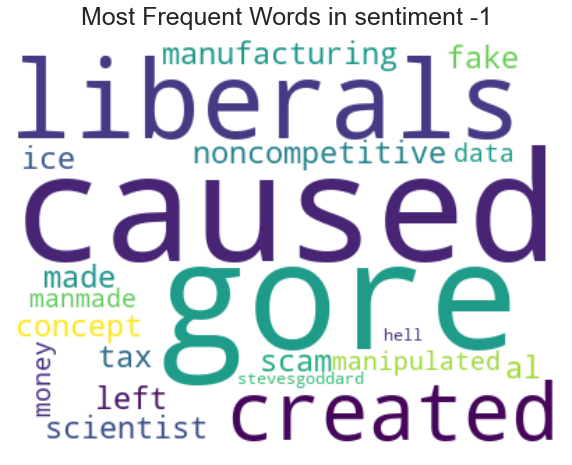

In [69]:
word_cloud(Negative, -1)

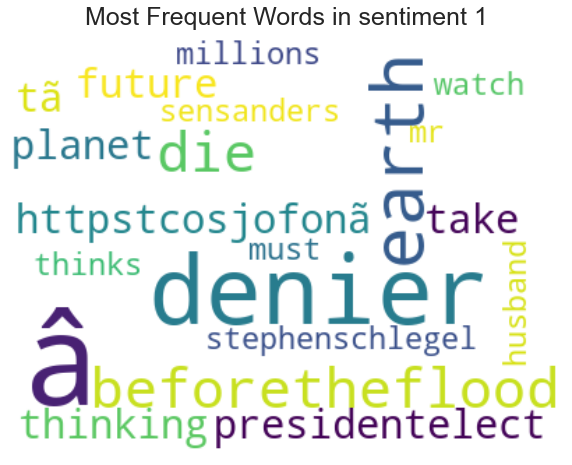

In [70]:
word_cloud(Positive, 1)

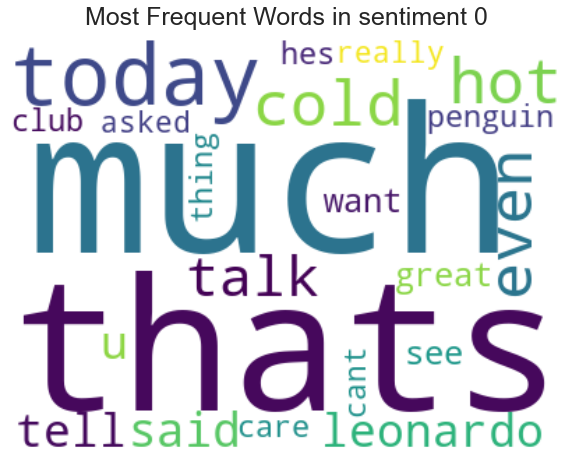

In [71]:
word_cloud(Neutral, 0)

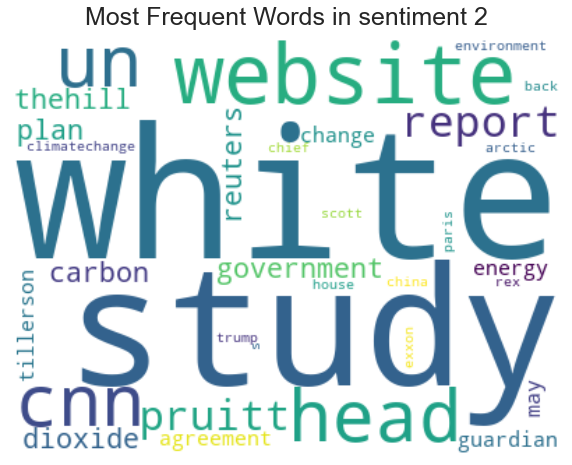

In [72]:
word_cloud(Factual, 2)

So far we've taken a look at what the most frequent words are per sentiment and have seen how factual comments differ from other comments after taking a look at the top 20 frequent words. A few words of interest are "epa", "news", "scientists" and "via" which all tend to be words use in a news site publication

**Note**, our data is still a bit noisy because we haven't taken care of the urls in each post yet and there's a lot of non-english words. But this gives us an idea.

**How many links are there in total? and How are they shared amongst the sentiments?**

In [73]:
# how many links there are
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
urls = []
for row in df['message']:
    match = re.findall(pattern_url, row)
    for item in match:
        urls.append(item)

total_links = len(urls)
print(total_links)

9673


Here we see that there are __9,673__ url links in the dataset.

In [74]:
# Number of links per sentiment

# copy dataframe to not change structure of main df
df_copy = df.copy()

# create new column `url
url = []

# find urls per row 
for row in df_copy['message']:
    match = re.findall(pattern_url, row)
    url.append(len(match)) # append the number of urls found per row
    
df_copy['url'] = url

df_copy.head()

,sentiment,message,tweetid,url
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,1
1,1,It's not like we lack evidence of anthropogeni...,126103,0
2,2,RT @RawStory: Researchers say we have three ye...,698562,2
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,1
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,0


In [75]:
maxf = max(list(df_copy.url))

df_copy[df_copy.url == maxf]

,sentiment,message,tweetid,url
2754,2,https://t.co/u4R1BqQ5UR | Parliament ratifies ...,104560,3
3233,2,https://t.co/B2Fk05gnwC Forbidden phrases at U...,954879,3
5715,2,Cloudy feedback on global warming - https://t....,659920,3
8297,1,RT @zoeschlanger: The https://t.co/O90Lo4IhlO ...,67703,3
9131,2,How climate change may drive extreme weather -...,338028,3
11256,2,RT @NaturePlants: Predicting rice yield losses...,273452,3


In [76]:
count_dict = {}

for l in df_copy.sentiment.unique():
    new_df = df_copy[df_copy.sentiment == l]
    count_dict[l] = sum(new_df.url)
    
count_dict

{1: 4199, 2: 4070, 0: 865, -1: 539}

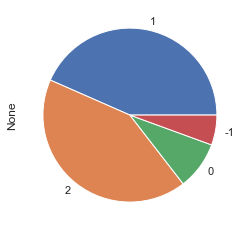

In [77]:
pd.Series(count_dict).plot(kind='pie')
plt.xticks(rotation=0)
plt.show()

Again, _positive_ and _factual_ comments lead the way, indicating that there may be more to gain from these urls, particularly in the case of the _factual_ comments which has more **urls** than it does **data points** (__4,070 :__ __3640__). This is by no means conclusive. 

Perhaps the model will tell us more eventually.

### Twitter Handles

A Twitter handle is the username that appears at the end of a unique Twitter URL. Twitter handles appear after the @ sign in the profile URL and it must be unique to a user account. A Twitter name, on the other hand, is simply there to help people find the company they’re looking for.

Let's see if we can get any information from the twitter handles in our data.

In [78]:
# Creating a function to extract handles from tweets
def extract_handles(x):
    handles = []
    for i in x:
        h = re.findall(r'@(\w+)', i)
        handles.append(h)
        
    return handles

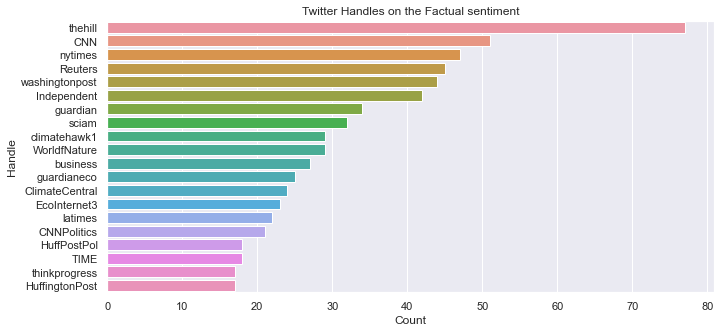

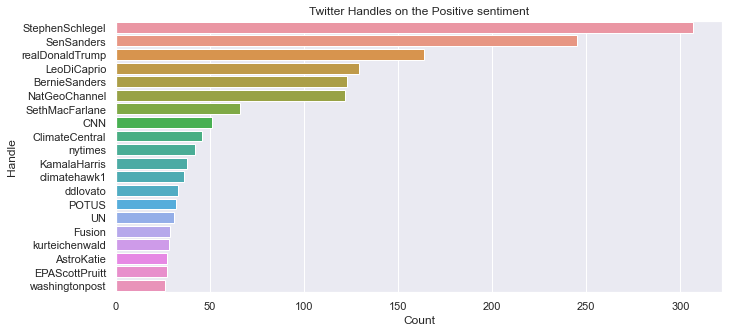

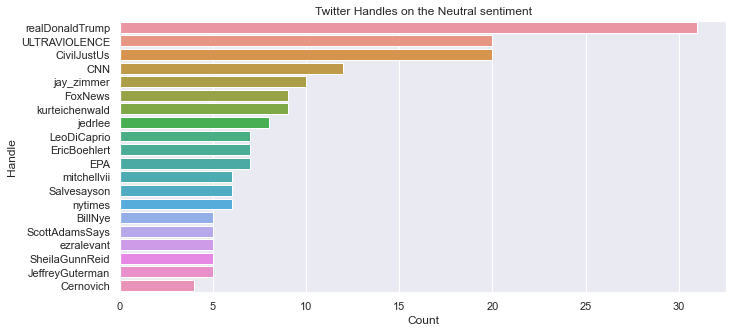

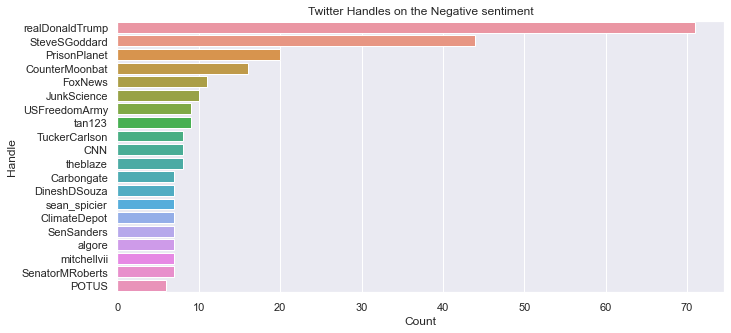

In [79]:
Factual = extract_handles(df_copy['message']
                              [df_copy['sentiment'] == 2])
Positive = extract_handles(df_copy['message']
                          [df_copy['sentiment'] == 1])
Neutral = extract_handles(df_copy['message']
                              [df_copy['sentiment'] == 0])
Negative = extract_handles(df_copy['message']
                          [df_copy['sentiment'] == -1])

# handle lists 
handles = [sum(Factual, []), sum(Positive, []), sum(Neutral, []),
           sum(Negative, [])]

# Visualising the Handles
full_title = ['Twitter Handles on the Factual sentiment',
              'Twitter Handles on the Positive sentiment',
              'Twitter Handles on the Neutral sentiment',
              'Twitter Handles on the Negative sentiment']

plt.rcParams['figure.figsize'] = [50, 5]

for i, sent in enumerate(handles):
    plt.subplot(1, 4, i + 1)
    freq_dist = nltk.FreqDist(sent)
    df = pd.DataFrame({'Handle': list(freq_dist.keys()),
                      'Count' : list(freq_dist.values())})

    df = df.nlargest(columns='Count', n=20)

    ax = sns.barplot(data=df, y='Handle', x='Count')
    plt.title(full_title[i])
    plt.show()

From the above visuals we can see that:
- The factual handles are real life News outlets
- Donald Trump is a leading voice in Neutral and Negative sentiments
- Politicians and celebrities take the biggest chunck of the positive sentiment
    

<a id="four"></a>
## 5. Data Engineering


### What is Data Engineering?

Data engineering is the process of creating features that allow machine learning algorithms to work utilizing domain knowledge of the data. Feature engineering is both difficult and expensive, but it is essential to the application of machine learning.

#### The Problem With Text Data

A major problem with *text* data is that it is very messy and requires a lot of cleaning. In addition to that, it comes in a form that will be very difficult to feed into our machine learning models and get meaningful results, if any for that matter.

A machine learning model only understands numbers in form of `ints` and `floats` and has a difficult time comprehending what alphabets represent.

To help our machine learn better and make its life more bearable, we will need to transform our text data into digits in such a way that translates what the text is to the machine in numbers, thereby retaining, up to level, the meanings of the text. To do this, we will be carrying out a concept called `Data Engineering`.

`Data Engineering` has been referred to a couple of times so far in this notebook, let's find out what it is next

#### Our Mission

- [X] Extract titles from Urls and incorporate findings into our data

- [X] Remove Stopwords

- [X] Remove hashtags and @usernames

- [X] Remove Punctuations

- [X] Tokenize text data

- [ ] Transform data(by stemming or lemmatizing)

- [ ] Vectorize data without resampling(by bag of words, countvectorizer or tfidfvectorizer)

- [ ] Vectorize data with resampling(by bag of words, countvectorizer or tfidfvectorizer)

In [26]:
def vectorize(data, features, label='sentiment', vectorizer="bow", n_features=20, n_grams=(1, 1)):
    
    words_count = {}
    bow = []
    
    for row in data:
        for word in row:
            if word in words_count:
                words_count[word] += 1
            else:
                words_count[word] = 1
    
    # sort words_count dict
    words_count = {k: v for k, v in sorted(words_count.items(), key=lambda kv: kv[1], reverse=True)}
    
    # get the no of features needed
    n_largest = dict(list(words_count.items())[:n_features])
    
    # vectorize 
    for row in data[features]:
        vector = []
        for word in n_largest.keys():
            if word in row:
                vector.append(1)
            else:
                vector.append(0)
        bow.append(vector)
        
    # convert features to category
    data[features] = data[features].astype('category')
    
    # options
    if vectorizer == 'tfidf':
        vector = TfidfVectorizer(lowercase=True, max_features=n_features,analyzer='word', ngram_range=n_grams)
        vectored = vector.fit_transform(data[features])
        vectored = vectored.toarray()
    elif vectorizer == 'cv':
        vector = CountVectorizer(lowercase=True, max_features=n_features,analyzer='word', ngram_range=n_grams)
        vectored = vector.fit_transform(data[features])
        vectored = vectored.toarray()
    else:
        vectored = np.asarray(bow)
        
    print(f"using {vector}")
    X = vectored
    y = data[label]
    
    return X, y
    

In [168]:
vector = []

for row in df['message']:
    sub_vect = []
    for j in n_largest.keys():
        if j in row.split(" "):
            sub_vect.append(1)
        else:
            sub_vect.append(0)
    vector.append(sub_vect)

X = vector


In [172]:
X[:10]

AttributeError: 'list' object has no attribute 'to_numpy'

In [90]:
def bag_of_words_count(words, word_dict={}):
    """ this function takes in a list of words and returns a dictionary 
        with each word as a key, and the value represents the number of 
        times that word appeared"""
    for word in words:
        if word in word_dict.keys():
            word_dict[word] += 1
        else:
            word_dict[word] = 1
    return word_dict

In [137]:
label = {}
for label_type in list(df.sentiment.unique()):
    data = df.groupby('sentiment')
    label[label_type] = {}
    for row in data.get_group(label_type)['message'].str.split(" "):
        label[label_type] = bag_of_words_count(row, label[label_type])

In [138]:
all_words = set()
for label_type in list(df.sentiment.unique()):
    for word in label[label_type]:
        all_words.add(word)

In [139]:
len(all_words)

45923

In [ ]:
label['all'] = {}
for label_type in list(df.sentiment.unique()):    
    for word in all_words:
        if word in label[label_type].keys():
            if word in label['all']:
                label['all'][word] += label[label_type][word]
            else:
                label['all'][word] = label[label_type][word]

In [ ]:
total_words = sum([v for v in label['all'].values()])

total_words

278862

Text(0.5, 0, 'word frequency')

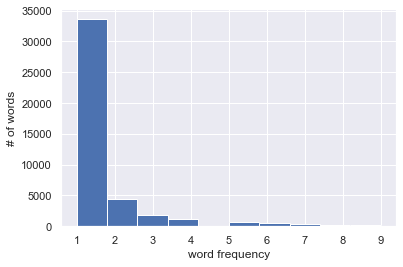

In [108]:
_ = plt.hist([v for v in label['all'].values() if v < 10],bins=10)
plt.ylabel("# of words")
plt.xlabel("word frequency")

In [109]:
len([v for v in label['all'].values() if v == 1])

33616

In [110]:
rare_words = [k for k, v in label['all'].items() if v==1] 
print(rare_words[:100])

['Hunton/Weindorf', '@treubold:', 'https://t.co/hyFV639fbi', 'Rosen,', 'https://t.co/TXjG0HwZWD', 'dig:', 'Wile', '@BretStephensNYT.', 'https://t.co/hotv3hRhaZ', 'https://t.co/y60BdLDO0U', 'https://t.co/JgUosRxVlf', 'https://t.co/xGa8rIgWwa', '#nowreading', 'http://www.c40/women4', '(@irinnews)', 'https://t.co/2ZqjuwMDVz', '@jackholmes0:', '@HopeFTFuture', '#Deplorables', "'why", '63%', '1,459)', 'hypocrite.', 'themselves!', '@RobinBHarding:', 'pop.', '@RKennedyob:', '(sniff)', '(if', '@MorrisseyHelena:', 'delivering', '30s', '(manmade,political,', 'AG,', 'DISAGREEMENT!', 'denialist.', '@staffo_sez:', '@jphever:', 'https://t.co/uZ2ykZiavE', '@PaulieMcGinty:', '@tcktcktck:', 'unproven', 'https://t.co/nFGYRdm98c', 'us,blacks', '@NaturalBAtheist:', 'Truue.', 'https://t.co/wbHsVugIn0', 'volatile', 'https://t.co/hisuYCHMGD', 'Anniversary', '@BRANDONWARDELL:', 'https://t.co/cYPCBZax3E', '@kikyowolf:', 'b/w', '#StopCpv', "*don't*", "mind,'", 'troll.', '#mediterranean', 'SoS', 'problems\nmost'

In [111]:
print(len([v for v in label['all'].values() if v >= 10]))
occurs_more_than_10_times = sum([v for v in label['all'].values() if v >= 10])
print(occurs_more_than_10_times)

2580
211652


In [112]:
print(occurs_more_than_10_times/total_words)

0.7589847307987463


In [113]:
max_count = 10
remaining_word_index = [k for k, v in label['all'].items() if v > max_count]

In [ ]:
hm = []
for p, p_bow in label.items():
    df_bow = pd.DataFrame([(k, v) for k, v in p_bow.items() if k in remaining_word_index], columns=['Word', p])
    df_bow.set_index('Word', inplace=True)
    hm.append(df_bow)

# create one big dataframe
df_bow = pd.concat(hm, axis=1)
df_bow.fillna(0, inplace=True)

In [ ]:
df_bow

,1,2,0,-1,all
Word,,,,,
EPA,191.0,227.0,15.0,12.0,445
chief,56.0,83.0,4.0,2.0,145
doesn't,689.0,21.0,47.0,18.0,775
think,220.0,15.0,81.0,27.0,343
carbon,82.0,62.0,11.0,13.0,168


In [66]:
def feature_selection(data, column_name):
    type_labels = data[column_name].unique()
    labels = {}
    for s in type_labels:
        data = data.groupby(column_name)
        labels[s] = {}
        for row in df.get_group(s)['tokens']:
            personality[pp] = bag_of_words_count(row, personality[pp])

In [240]:
word = handle_weblinks('today is the best day of my life https://t.co/rWCW2XF2lr')
# word = remove_stopwords(word)
# word = remove_punctuations(word)
# word = tokenize(word)
# word = transform(word, method='lemma')
print(word)

today is the best day of my life World food supplies at risk as climate change threatens international trade, warn experts | The Independent | The Independent


1. ###  Extracting Titles for Urls

To achieve this goal, we will need to create a few functions for a cleaner process

In this section, we will extract the urls from the tweets and scrape the title from the webpage the url links to and then replace url with the title of the webpage to give the tweet message more context

There are cases where the tweet made and the title of the url extracted from the tweet are the same. This is a problem because the end goal of the extraction and handling of the url is to replace the url with the scraped title of the website, and with the tweet and the message being similar, it will lead to duplication of tweet message which will blow up the count of some words in the long run.

Let us look at an example: for tweet indexed 14551

In [28]:
tweet = df_copy.message[14551]
print(tweet)

In rare move, China criticizes Trump plan to exit climate change pact https://t.co/svDExQ7mlA via @Reuters


In [29]:
match = re.findall(pattern_url, tweet)
print(match)

['https://t.co/svDExQ7mlA']


In [30]:
for url in match:
    response = requests.get(url,verify=False)
    soup = BeautifulSoup(response.text, 'html.parser')
    for title in soup.find_all('title'):
        print(title.get_text())

In rare move, China criticizes Trump plan to exit climate change pact | Reuters


As we can see, the title is exactly the same as the message in the tweet. We do not want this to happen. To handle this problem, we will create a function that checks the similarity between the tweet message and the title from the url. Given a threshold, at about 40%, if the similarity between both texts is greater than or equal to the threshold, the url in the tweet message is replaced with _facturl_.

In [139]:
def check_title_similarity(text, title):
    """
    This function checks the similarity between
    the tweet message and the title scraped from
    the url link.
    """
    text = text.split(" ")
    title = title.split(" ")
    text_counter = set()
    title = set(title)
    
    for txt in title:
        if txt in text:
            text_counter.add(txt)
    
    perc_similarity = (len(text_counter)/len(title))*100
    
    return perc_similarity

In [14]:
def extract(url):
    url_titles = []
    try:
        try:
            response = requests.get(url,verify=False, timeout=15)

        except:
            url = 'https://www.google.com'

        finally:
            response = requests.get(url,verify=False)
            soup = BeautifulSoup(response.text, 'html.parser')
            for title in soup.find_all('title'):
                if title:
                    return title.get_text()
                else:
                    return ("")
    except:
        pass

Due to the size of our dataset, it will be difficult and computationally expensive to extract the urls from the tweets and get the url info and extract the title of the web page the url links to. That doesn't sound too difficult, but for a dataset in the tens of thousands, it is massively difficult especially on an average pc.

To help us with this problem, we employ the services of __multithreading__. A brief introduction into this concept will only be proper.

**What is Multithreading?**

- Multithreading is a popular Python technique that allows numerous jobs to run at the same time. Multithreading, in simple terms, is the ability of a processor to run many [threads](https://www.scaler.com/topics/multithreading-in-python) at the same time. 

Another concept of note is a concept called **[multiprocessing](https://www.scaler.com/topics/multithreading-in-python)** click on the link to read more.

We are going to be making use of the package `concurrent.futures`, it already exists in python's standard library so you do not need to install it.

In [15]:
def download_titles(urls):
    import concurrent.futures
    titles = []
    MAX_THREADS = 30
    start = time.perf_counter()
    
    threads = min(MAX_THREADS, len(urls))
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=threads) as executor:
        title = executor.map(extract, urls)
        for i, tit in enumerate(title):
            titles.append(tit)
            print(i, tit)
            
    end = time.perf_counter() - start
    
    print(f"done {len(urls)} in {end} secs")
    
    return titles

We have created a function above called `download_titles` which makes use of python's multithreading which maps the `extract` function over each url in a list of urls

Below, we create a function to extract the urls from the `message` column

In [27]:
def extract_urls(arr):

    urls = []
    count = 0
    start = time.perf_counter()
    
    for m in arr:
        pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
        match = re.search(pattern_url, m)
        
        if match is not None:
            urls.append(match.group())
            
        else:
            urls.append(None)
            
        count += 1
        
    tots = time.perf_counter() - start
    
    return urls

In [29]:
messages = np.array(df['message'])
url_list = extract_urls(messages)

The code below calls the `download_titles` function and stores the downloaded titles in a titles variable. 

**Warning:** this bit practically took about an hour and three quarters to execute, don't believe me? here's proof; [done **15819** jobs in **5746.6804334 secs**  that is about **1 hour, 40 mins**]. 

Still don't believe me? grab a cup of coffee, some snacks and turn on Netflix to your favorite show and have at it, because it is going to take that long. 

Well... except your machine is way better than mine ...and i bet it is.

In [31]:
# titles = download_titles(url_list)

# titles

The result of the above code has been saved into a CSV file as `titles.csv` and can be read in for ease of use.

In [85]:
titles = pd.read_csv('titles.csv')

titles.head()

,Unnamed: 0,0
0,0,EPA chief denies carbon dioxide is main cause ...
1,1,Google
2,2,Google
3,3,2016 Was a Pivotal Year in the War on Climate ...
4,4,Google


Let's clean up a bit

- #### Cleaning *titles* dataframe

We will drop the unwanted column `unnamed:0` because it is merely an index column that came with the file and give the column containing titles a befitting name

In [86]:
titles.drop('Unnamed: 0', axis=1, inplace=True)
titles.columns = ['title']

titles.head()

,title
0,EPA chief denies carbon dioxide is main cause ...
1,Google
2,Google
3,2016 Was a Pivotal Year in the War on Climate ...
4,Google


That looks better

*Google* is only a placeholder for links that lead nowhere or have restrictions and will not be treated as text of interest but remove.

There are some rows with invalid data or website error messages such *404 Not Found* etc. We have a list of titles to remove and are stored in `titles.txt` file. Let's read that in.

In [48]:
with open('titles.txt', 'r') as file:
    bad_titles = file.readlines()
    file.close()
    
bad_titles = [w.replace('\n', '') for w in bad_titles]
bad_titles

['google',
 'none',
 '403 forbidden',
 'file not found',
 'page not found',
 '404 not found',
 '404 page not found',
 'twitter',
 'youtube',
 'scihubbz',
 'tco twitter',
 '500 internal server error',
 'short url blocked',
 'Sorry something went wrong',
 'attention required',
 'error',
 '405 You have been blacklisted',
 'not acceptable',
 'facebook',
 'sciencedirect',
 'are you a robot',
 'just a moment',
 'whoops',
 'service unavailable']

In [91]:
titles.fillna('google', inplace=True)

Again, 'google' is just a placeholder

Next, we will remove punctuations from our `titles` dataframe, employing the use of the `remove_punctuation` function

In [70]:
def remove_punctuations(text):
    import re
    # using regex to remove punctuations
    text = re.sub(r'[^\w\s]', '', text)
    
    return text

In [93]:
titles['title'] = titles['title'].apply_parallel(remove_punctuations)

Now, Let's remove those bad titles.

We will approach this by using the `*.__contains__*` string class method

In [113]:
def remove_bad_titles(title, remove_titles=bad_titles):
    title = title.lower()
    title = title.strip()
    for bt in remove_titles:
        if title.__contains__(bt):
            split_title = title.split(bt)
            title = "".join(split_title)
    
    return title

In [114]:
titles['title'] = titles['title'].apply_parallel(remove_bad_titles)

In [116]:
titles['title'].head()

0    epa chief denies carbon dioxide is main cause ...
1                                                     
2                                                     
3    2016 was a pivotal year in the war on climate ...
4                                                     
Name: title, dtype: object

Okay! everything is looking good thus far

- #### Merge tweet messages with extracted titles

Next, lets merge these titles to our tweet messages

In [159]:
def merge_msg(main_df, main_col, title_df, title_col):
    rows = []
    
    for i in range(len(title_df)):
        if check_title_similarity(main_df[main_col][i], title_df[title_col][i]) >= 30:
            rows.append(main_df[main_col][i])
        else:
            rows.append(main_df[main_col][i] +' '+ title_df[title_col][i])
        
    main_df[main_col] = rows
    
    return main_df

In [ ]:
df = merge_msg(df, 'message', titles, 'title')

In [176]:
df.head().to_numpy()

array([[1,
        "polyscimajor epa chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!?  via @mashable",
        625221],
       [1,
        "it's not like we lack evidence of anthropogenic global warming",
        126103],
       [2,
        'rt @rawstory: researchers say we have three years to act on climate change before its too late',
        698562],
       [1,
        '#todayinmaker# wired : 2016 was a pivotal year in the war on climate change',
        573736],
       [1,
        "rt @soynoviodetodas: it's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #electionnight",
        466954]], dtype=object)

It is evident that there has been a successful merger.

Next we remove the links in each message as we have already extracted information from the useful ones

- #### Remove web links from text

In [172]:
def handle_weblinks(text):
    import re
    pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
    match = re.findall(pattern_url, text)
    
    for sub in match:
        text = re.sub(pattern_url, '', text)
    
    return text.strip().lower()

In [173]:
df['message'] = df['message'].apply_parallel(handle_weblinks)

In [174]:
np.array(df['message'])[:10]

array(["polyscimajor epa chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!?  via @mashable",
       "it's not like we lack evidence of anthropogenic global warming",
       'rt @rawstory: researchers say we have three years to act on climate change before its too late',
       '#todayinmaker# wired : 2016 was a pivotal year in the war on climate change',
       "rt @soynoviodetodas: it's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #electionnight",
       "worth a read whether you do or don't believe in climate change   how to teach kids about climate change where most parents are skeptics  the washington post",
       'rt @thenation: mike pence doesnt believe in global warming or that smoking causes lung cancer.  the nation',
       'rt @makeandmendlife: six big things we can all do today to fight climate change, or how to be a climate activist  h sustainableish',
       '@aceofspadeshq my 8yo nephew is inconsolab

Okay! that's done. We have successfully finished the first mission. Hurray!

- [X] Extract titles from Urls and incorporate findings into our data

Next up on our mission is to remove stopwords from our texts

2. ###  Remove Stopwords

#### What are Stopwords?

Stopwords are words that are quite common in human language but are often useless since they represent words like "the," "of," and "to."

Apart from the universally known stopwords, there are words that are perculiar to some industries or particular topics and content that may be regarded as stop words. For instance, in our case where we are dealing with tweets, "RT" which stands for "Retweet" can be considered a stop word, also @Usernames and #topics may be considered as stopwords.

Let's remove these bits of texts from the messages in our dataset

In [178]:
def remove_stopwords(text):
    text = text.lower()
    stop_words = stopwords.words('english')
    stop_words.append("rt")
    text = " ".join([word for word in text.split(" ") if word not in stop_words])
    
    return text

In [180]:
df['message'] = df['message'].apply(remove_stopwords)

In [181]:
df.head()

,sentiment,message,tweetid
0,1,polyscimajor epa chief think carbon dioxide ma...,625221
1,1,like lack evidence anthropogenic global warming,126103
2,2,@rawstory: researchers say three years act cli...,698562
3,1,#todayinmaker# wired : 2016 pivotal year war c...,573736
4,1,"@soynoviodetodas: 2016, racist, sexist, climat...",466954


- [X] Remove stopwords

3. ###  Remove tagged usernames and hashtags

In [229]:
def remove_tags(text):
    pattern_hash = r'[#@](?:[A-Za-z]|[0-9]|[$-_@.&+#])+'
    match = re.findall(pattern_hash, text)
    
    for sub in match:
        text = re.sub(pattern_hash, '', text)

    return text.strip()

In [232]:
df['message'] = df['message'].apply(remove_tags)

In [233]:
df.head()

,sentiment,message,tweetid
0,1,polyscimajor epa chief think carbon dioxide ma...,625221
1,1,like lack evidence anthropogenic global warming,126103
2,2,researchers say three years act climate change...,698562
3,1,wired : 2016 pivotal year war climate change,573736
4,1,"2016, racist, sexist, climate change denying b...",466954


Next, we will be getting rid of punctuations from out dataset.

- [X] Remove usernames and hashtags

4. ### Remove Punctuations

Here we will be making use of the `remove_punctuations` function

In [234]:
df['message'] = df['message'].apply(remove_punctuations)

In [236]:
df.head()

,sentiment,message,tweetid
0,1,polyscimajor epa chief think carbon dioxide ma...,625221
1,1,like lack evidence anthropogenic global warming,126103
2,2,researchers say three years act climate change...,698562
3,1,wired 2016 pivotal year war climate change,573736
4,1,2016 racist sexist climate change denying bigo...,466954


- [X] Remove punctuations

#### Mission Check Point

- [X] Extract titles from Urls and incorporate findings into our data

- [X] Remove Stopwords

- [X] Remove hashtags and @usernames

- [X] Remove Punctuations

- [ ] Tokenize text data

- [ ] Transform data(by stemming or lemmatizing)

- [ ] Vectorize data without resampling(by bag of words, countvectorizer or tfidfvectorizer)

- [ ] Vectorize data with resampling(by bag of words, countvectorizer or tfidfvectorizer)

Next item on our mission list is to tokenize text data

5. ### Tokenize Text Data

Tokenization is the most primary step in any natural language processing model because machines cannot comprehend the language as it is, it must be transformed to numbers, which is where tokenization comes in handy. Tokenization is the process of breaking down sentences into words.

This appears straightforward, but there are a few drawbacks, mostly because we want to map each token to a number, and the size and meaning of the resulting mapping is vital for Machine Learning tasks.

There are a few tokenizers available, but for this program, we will be making use of the `TreebankWordTokenizer()`

In [237]:
def tokenize(text):
    tokenizer = TreebankWordTokenizer()
    
    return tokenizer.tokenize(text)

In [238]:
df['message'] = df['message'].apply(tokenize)

In [239]:
df.head()

,sentiment,message,tweetid
0,1,"[polyscimajor, epa, chief, think, carbon, diox...",625221
1,1,"[like, lack, evidence, anthropogenic, global, ...",126103
2,2,"[researchers, say, three, years, act, climate,...",698562
3,1,"[wired, 2016, pivotal, year, war, climate, cha...",573736
4,1,"[2016, racist, sexist, climate, change, denyin...",466954


- [X] Token Text Data

6. ### Transform data(by stemming or lemmatizing)

**Stemming** is the process of stripping a word of its suffix and reducing it to its underlying term.

For example: “Flying” is a word and its suffix is “ing”, if we remove “ing” from “Flying” then we will get base word or root word which is “Fly”. Read more about stemming [here](https://medium.com/@tusharsri/nlp-a-quick-guide-to-stemming-60f1ca5db49e#:~:text=NLP%3A%20A%20quick%20guide%20to%20Stemming%201%20OverStemming.,...%205%20Lancaster%20Stemmmer.%20...%206%20Conclusion.%20)

**Lemmatization** is not very different from **stemming** in that we are trying to reduce a given term to its root word in both stemming and lemmatization. In Natural Language Processing (NLP) and machine learning in general, lemmatization is one of the most used text pre-processing techniques. In the stemming process, the root word is termed a stem, and in the lemmatization process, it is called a lemma.

#### How do they differ?

In stemming, a portion of the word is simply sliced off at the end. Different methods are employed to determine how many letters must be removed, however the algorithms do not understand the meaning of the word in the language it belongs to. The algorithms in lemmatization, on the other hand, have this knowledge. In fact, you could argue that these algorithms consult a dictionary to figure out what a word means before reducing it to its root word, or lemma.
As a result, a lemmatization algorithm would recognize that **better** is derived from good, and hence the lemme is **good**.

A stemming algorithm, on the other hand, would be unable to do so. Over-stemming or under-stemming may occur, and the term **better** may be shortened to **bet** or **bett**, or simply **preserved as better**. However, there is no way to reduce it to its underlying word excellent by stemming. This is the main distinction between stemming and lemmatization.

In [270]:
def transform(text_list, method='stem'):
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()
    words = []
    if method == 'lemma':
        for word in text_list:
            word = lemmatizer.lemmatize(word)
            words.append(word)

    elif method == 'stem':
        for word in text_list:
            word = stemmer.stem(word)
            words.append(word)
            
    else:
        return(f"ERROR: '{method}' is an unknown transformation method use 'stem' or 'lemma'")

    return words

In [271]:
df['message'] = df['message'].apply(transform)

In [272]:
df.head()

,sentiment,message,tweetid
0,1,"[polyscimajor, epa, chief, think, carbon, diox...",625221
1,1,"[like, lack, evid, anthropogen, global, warm]",126103
2,2,"[research, say, three, year, act, climat, chan...",698562
3,1,"[wire, 2016, pivot, year, war, climat, chang]",573736
4,1,"[2016, racist, sexist, climat, chang, deni, bi...",466954


- [X] Transform data(by stemming or lemmatizing)

In [212]:
def resampler(data, y, kind='balance'):
    from sklearn.utils import resample
    from imblearn.over_sampling import SMOTE
    from imblearn.combine import SMOTETomek
    from imblearn.combine import SMOTEENN
    
    # separate the values
    y_values = {}
    
    for value in data[y].unique():
        value_list = data[data[y] == value]
        y_values[value] = len(value_list)
        
    # get value with max count
    values = data[y].value_counts()
    min_ = min(list(y_values.values()))
    max_ = max(list(y_values.values()))
    value_max = values[values == max_].index.values[0]
    value_min = values[values == min_].index.values[0]
    emp_df = pd.DataFrame()
    sampled =[]
    
    if kind == 'downsample':
        min_df = data[data[y] == value_min]
        for i in y_values.keys():
            if i != value_min:   
                sampling = resample(data[data[y] == i], replace=False, n_samples=y_values[value_min], random_state=27)
                sampled.append(sampling)    
        sampled.append(min_df)
        
    elif kind == 'upsample':
        max_df = data[data[y] == value_max]
        for i in y_values.keys():
            if i != value_max:   
                sampling = resample(data[data[y] == i], replace=True, n_samples=y_values[value_max], random_state=27)
                sampled.append(sampling)    
        sampled.append(max_df)  
    
    elif kind == 'balance':
        resample_size = int(max_/2)
        for i in y_values.keys():
            sampling = resample(data[data[y] == i], replace=True, n_samples=resample_size, random_state=27)
            sampled.append(sampling)
            
        
    for sample in sampled:
        emp_df = pd.concat([emp_df,sample])
    
    return emp_df
    # return resample_size

In [333]:
resampler(df, 'sentiment', 'balance')

,sentiment,message,tweetid
9628,1,RT @jimsciutto: We are in a parallel universe ...,98572
7064,1,Our inaction on climate change will be the bla...,77569
7333,1,RT @LibyaLiberty: This was an eye opener - how...,399472
9107,1,@IvankaTrump - so much for making climate chan...,177571
13358,1,RT @krystalball: A little girl just asked @jas...,781743
...,...,...,...
4130,-1,The priority for most Africans is getting food...,517059
9768,-1,RT @realDonaldTrump: The concept of global war...,759713
1052,-1,RT @CattHarmony: I'd rather #MarchforBabies th...,189585
6937,-1,"RT @loftyjester: Of course they have, fuck all...",763763


<a id="five"></a>
## 6. Modelling
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>


In [216]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)# split data

In [217]:
logreg = LogisticRegression(multi_class='ovr')

In [218]:
logreg.fit(X_train, y_train)

LogisticRegression(multi_class='ovr')

In [219]:
y_pred = logreg.predict(X_test)

In [220]:
rfc = RandomForestClassifier()

In [221]:
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [222]:
rfc_pred = rfc.predict(X_test)

<a id="six"></a>
## 7. Model Performance
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>


In [223]:
# Compare model performance
import warnings
warnings.filterwarnings('ignore')
classification = classification_report(y_test, y_pred, target_names=['-1', '0', '1', '2'])

print(classification)

              precision    recall  f1-score   support

          -1       0.43      0.06      0.10       219
           0       0.41      0.18      0.25       461
           1       0.67      0.82      0.74      1759
           2       0.59      0.62      0.60       725

    accuracy                           0.63      3164
   macro avg       0.53      0.42      0.43      3164
weighted avg       0.60      0.63      0.59      3164



In [224]:
# Choose best model and motivate why it is the best choice

classification = classification_report(y_test, rfc_pred, target_names=['-1', '0', '1', '2'])

print(classification)

              precision    recall  f1-score   support

          -1       0.32      0.15      0.20       219
           0       0.41      0.25      0.31       461
           1       0.67      0.78      0.72      1759
           2       0.60      0.62      0.61       725

    accuracy                           0.62      3164
   macro avg       0.50      0.45      0.46      3164
weighted avg       0.59      0.62      0.60      3164



In [225]:
test = pd.read_csv('kaggle_data/test.csv')

In [226]:
test.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


In [227]:
test_x = vector.fit_transform(test.message).toarray()

In [228]:
pred_y = rfc.predict(test_x)

In [229]:
pred_y

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [230]:
#baseline submission

In [231]:
submission_sample = pd.read_csv('kaggle_data/sample_submission.csv')

In [232]:
submission_sample.head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,1


In [233]:
y_pred

array([ 1, -1,  1, ...,  1,  0,  1], dtype=int64)

In [234]:
sub_file = submission_sample.copy()

In [235]:
sub_file.tweetid = test.tweetid

In [236]:
sub_file.sentiment= pred_y

In [237]:
sub_file.head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,1


In [238]:
sub_file.to_csv("baseline.csv", index=False)

In [239]:
submission_sample.head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,1


<a id="seven"></a>
## 8. Model Explanations
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>


In [ ]:
# discuss chosen methods logic